In [1]:
import pickle
with open('/kaggle/input/full-imgs/X_full.pickle', 'rb') as f:
    X = pickle.load(f)

with open('/kaggle/input/full-imgs/Y_full.pickle', 'rb') as f:
    Y = pickle.load(f)

In [2]:
import cv2
import numpy as np
from tensorflow.image import resize
import numpy as np
import tensorflow as tf

# Fixar a semente para operações determinísticas
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()


# Supondo que X seja uma lista de imagens coloridas.
X_resized = np.array([resize(image, [224, 224]) for image in X])
imagens_cinza = np.array([cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2GRAY) for image in X_resized])

def converter_para_rgb(imagens_cinza):
    imagens_rgb = np.stack((imagens_cinza,) * 3, axis=-1)
    return imagens_rgb

imagens_rgba = converter_para_rgb(imagens_cinza)


imagens_rgba[0].shape
#X = preprocess_input(imagens_rgba)
X = imagens_rgba
X.shape


# Convertendo a lista em um array NumPy
X_train = np.array(X)

2024-07-15 18:41:10.569164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 18:41:10.569289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 18:41:10.741068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
X.shape

(843, 224, 224, 3)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:

from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score



# Função para pré-processar a imagem
def preprocess_image(image, model_name):
    if model_name == 'vgg':
        return preprocess_vgg(image)
    elif model_name == 'resnet':
        return preprocess_resnet(image)
    elif model_name == 'inception':
        return preprocess_inception(image)
    elif model_name == 'mobilenet':
        return preprocess_mobilenet(image)
    elif model_name == 'efficientnet':
        return preprocess_efficientnet(image)

# Redimensionar todas as imagens para 224x224
def resize_image(image):
    return tf.image.resize(image, (224, 224))

# Carregar os modelos base sem a camada fully connected
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Função para extrair features
def extract_features(model, images, model_name):
    preprocessed_images = np.array([preprocess_image(resize_image(img), model_name) for img in images])
    features = model.predict(preprocessed_images)
    return features.reshape(features.shape[0], -1)


# Extrair features para o conjunto de treinamento
features_vgg_train = extract_features(base_model_vgg, X_train, 'vgg')
features_resnet_train = extract_features(base_model_resnet, X_train, 'resnet')
features_inception_train = extract_features(base_model_inception, X_train, 'inception')
features_mobilenet_train = extract_features(base_model_mobilenet, X_train, 'mobilenet')
features_efficientnet_train = extract_features(base_model_efficientnet, X_train, 'efficientnet')

# Concatenar as features extraídas
combined_features_train = np.concatenate([
    features_vgg_train, 
    features_resnet_train, 
    features_inception_train, 
    features_mobilenet_train, 
    features_efficientnet_train
], axis=1)

# Extrair features para o conjunto de teste
features_vgg_test = extract_features(base_model_vgg, X_test, 'vgg')
features_resnet_test = extract_features(base_model_resnet, X_test, 'resnet')
features_inception_test = extract_features(base_model_inception, X_test, 'inception')
features_mobilenet_test = extract_features(base_model_mobilenet, X_test, 'mobilenet')
features_efficientnet_test = extract_features(base_model_efficientnet, X_test, 'efficientnet')

# Concatenar as features extraídas
combined_features_test = np.concatenate([
    features_vgg_test, 
    features_resnet_test, 
    features_inception_test, 
    features_mobilenet_test, 
    features_efficientnet_test
], axis=1)

# Escalar as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(combined_features_train)
X_test_scaled = scaler.transform(combined_features_test)

# Treinar o classificador SVM com kernel sigmoide
classifier = SVC(kernel='sigmoid', random_state = 42)
classifier.fit(X_train_scaled, Y_train)

# Avaliar o modelo
Y_pred = classifier.predict(X_test_scaled)

# Acurácia
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Acurácia: {accuracy:.4f}")
print(classification_report(Y_test, Y_pred))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 348ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 338ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 522ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 401ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 598ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step 
Acurácia: 0.8639
              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89        95
         1.0       0.96      0.72      0.82        74

    accuracy                           0.86       169
   macro avg       0.89      0.85      0.86       169
weighted avg       0.88      0.86      0.86       169



In [11]:
# Imports necessários
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# SVM com Kernel Sigmoide
classifier_sigmoid = SVC(kernel='sigmoid', random_state = 42)
classifier_sigmoid.fit(X_train_scaled, Y_train)
Y_pred_sigmoid = classifier_sigmoid.predict(X_test_scaled)
print("Kernel Sigmoide")
print(classification_report(Y_test, Y_pred_sigmoid))
accuracy_sigmoid = accuracy_score(Y_test, Y_pred_sigmoid)
print(f"Acurácia: {accuracy_sigmoid:.4f}\n")

# SVM com Kernel RBF
classifier_rbf = SVC(kernel='rbf', random_state = 42)
classifier_rbf.fit(X_train_scaled, Y_train)
Y_pred_rbf = classifier_rbf.predict(X_test_scaled)
print("Kernel RBF")
print(classification_report(Y_test, Y_pred_rbf))
accuracy_rbf = accuracy_score(Y_test, Y_pred_rbf)
print(f"Acurácia: {accuracy_rbf:.4f}\n")

# SVM com Kernel Linear
classifier_linear = SVC(kernel='linear', random_state = 42)
classifier_linear.fit(X_train_scaled, Y_train)
Y_pred_linear = classifier_linear.predict(X_test_scaled)
print("Kernel Linear")
print(classification_report(Y_test, Y_pred_linear))
accuracy_linear = accuracy_score(Y_test, Y_pred_linear)
print(f"Acurácia: {accuracy_linear:.4f}\n")


Kernel Sigmoide
              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89        95
         1.0       0.96      0.72      0.82        74

    accuracy                           0.86       169
   macro avg       0.89      0.85      0.86       169
weighted avg       0.88      0.86      0.86       169

Acurácia: 0.8639

Kernel RBF
              precision    recall  f1-score   support

         0.0       0.69      0.99      0.81        95
         1.0       0.97      0.42      0.58        74

    accuracy                           0.74       169
   macro avg       0.83      0.70      0.70       169
weighted avg       0.81      0.74      0.71       169

Acurácia: 0.7396

Kernel Linear
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90        95
         1.0       0.90      0.82      0.86        74

    accuracy                           0.88       169
   macro avg       0.88      0.88      0.88       1

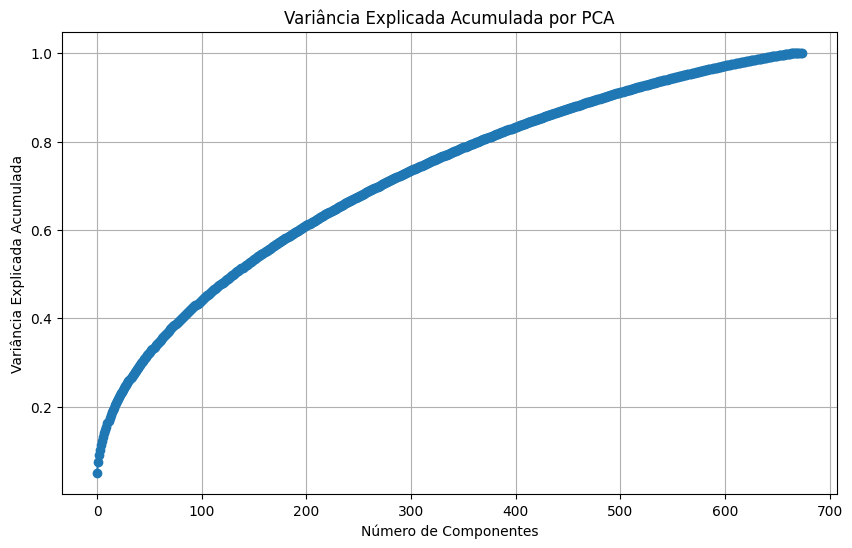


Avaliando para 0% de variância explicada:
Número de componentes para explicar 0% da variância: 1
Tamanho das features depois do PCA (train): (674, 1)
Tamanho das features depois do PCA (test): (169, 1)
              precision    recall  f1-score   support

         0.0       0.47      0.46      0.47        95
         1.0       0.33      0.34      0.33        74

    accuracy                           0.41       169
   macro avg       0.40      0.40      0.40       169
weighted avg       0.41      0.41      0.41       169

Acurácia: 0.4083

Avaliando para 5% de variância explicada:
Número de componentes para explicar 5% da variância: 2
Tamanho das features depois do PCA (train): (674, 2)
Tamanho das features depois do PCA (test): (169, 2)
              precision    recall  f1-score   support

         0.0       0.42      0.46      0.44        95
         1.0       0.22      0.19      0.20        74

    accuracy                           0.34       169
   macro avg       0.32      0.3

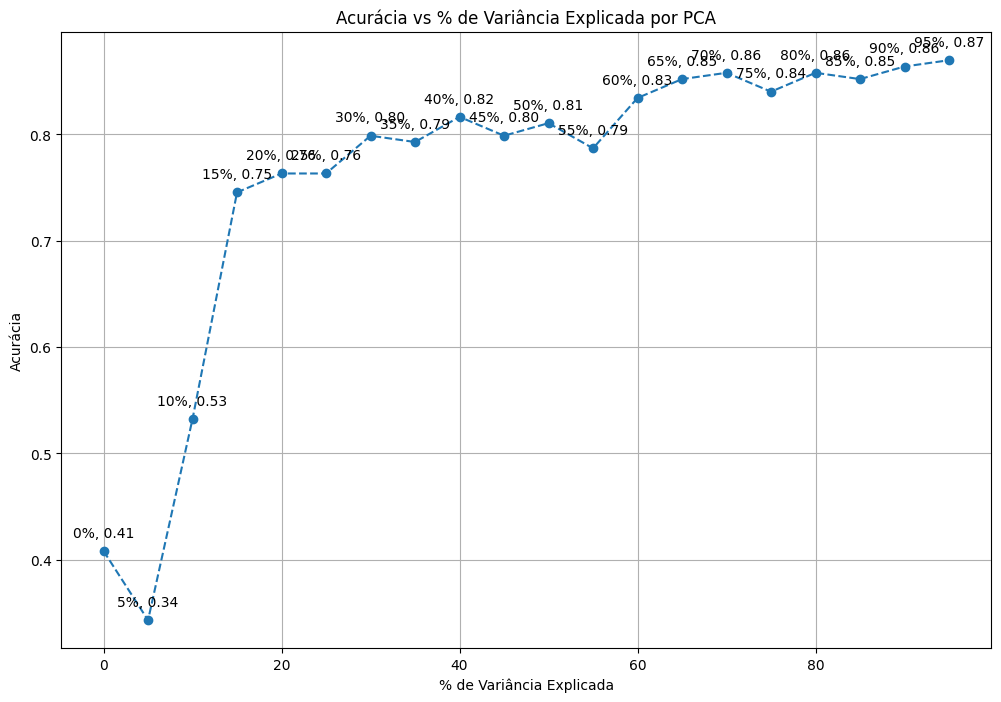

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

# Fixar a semente para operações determinísticas
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Função para treinar e avaliar o modelo e retornar a acurácia
def train_evaluate_pca_variance(explained_variance_threshold):
    # Determinar o número de componentes para o limiar de variância explicada
    n_components = np.argmax(explained_variance >= explained_variance_threshold) + 1

    print(f"Número de componentes para explicar {int(explained_variance_threshold * 100)}% da variância: {n_components}")

    # Aplicar PCA com o número de componentes determinado
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(combined_features_train_scaled)
    X_test_pca = pca.transform(combined_features_test_scaled)

    # Imprimir o tamanho das features depois do PCA
    print(f"Tamanho das features depois do PCA (train): {X_train_pca.shape}")
    print(f"Tamanho das features depois do PCA (test): {X_test_pca.shape}")

    # Treinar o classificador SVM com kernel sigmoide
    classifier = SVC(kernel='sigmoid',random_state = 42)
    classifier.fit(X_train_pca, Y_train)

    # Avaliar o modelo
    Y_pred = classifier.predict(X_test_pca)

    # Imprimir o relatório de classificação
    print(classification_report(Y_test, Y_pred))

    # Calcular e imprimir a acurácia
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f"Acurácia: {accuracy:.4f}")
    
    return accuracy



# Concatenar as features extraídas
combined_features_train = np.concatenate([
    features_vgg_train, 
    features_resnet_train, 
    features_inception_train, 
    features_mobilenet_train, 
    features_efficientnet_train
], axis=1)

combined_features_test = np.concatenate([
    features_vgg_test, 
    features_resnet_test, 
    features_inception_test, 
    features_mobilenet_test, 
    features_efficientnet_test
], axis=1)

# Escalar as features antes de aplicar PCA
scaler = StandardScaler()
combined_features_train_scaled = scaler.fit_transform(combined_features_train)
combined_features_test_scaled = scaler.transform(combined_features_test)

# Aplicar PCA inicial para determinar a variância explicada acumulada
pca = PCA().fit(combined_features_train_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotar a variância explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por PCA')
plt.grid(True)
plt.show()

# Testar diferentes limiares de variância explicada e armazenar resultados
variances = np.arange(0, 1.0, 0.05)
accuracies = []

for threshold in variances:
    print(f"\nAvaliando para {int(threshold * 100)}% de variância explicada:")
    accuracy = train_evaluate_pca_variance(threshold)
    accuracies.append(accuracy)

# Plotar o gráfico de % de variância explicada vs acurácia com anotações
plt.figure(figsize=(12, 8))
plt.plot(variances * 100, accuracies, marker='o', linestyle='--')
plt.xlabel('% de Variância Explicada')
plt.ylabel('Acurácia')
plt.title('Acurácia vs % de Variância Explicada por PCA')
plt.grid(True)

# Adicionar anotações aos pontos
for i, (var, acc) in enumerate(zip(variances * 100, accuracies)):
    plt.annotate(f'{var:.0f}%, {acc:.2f}', (var, acc), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


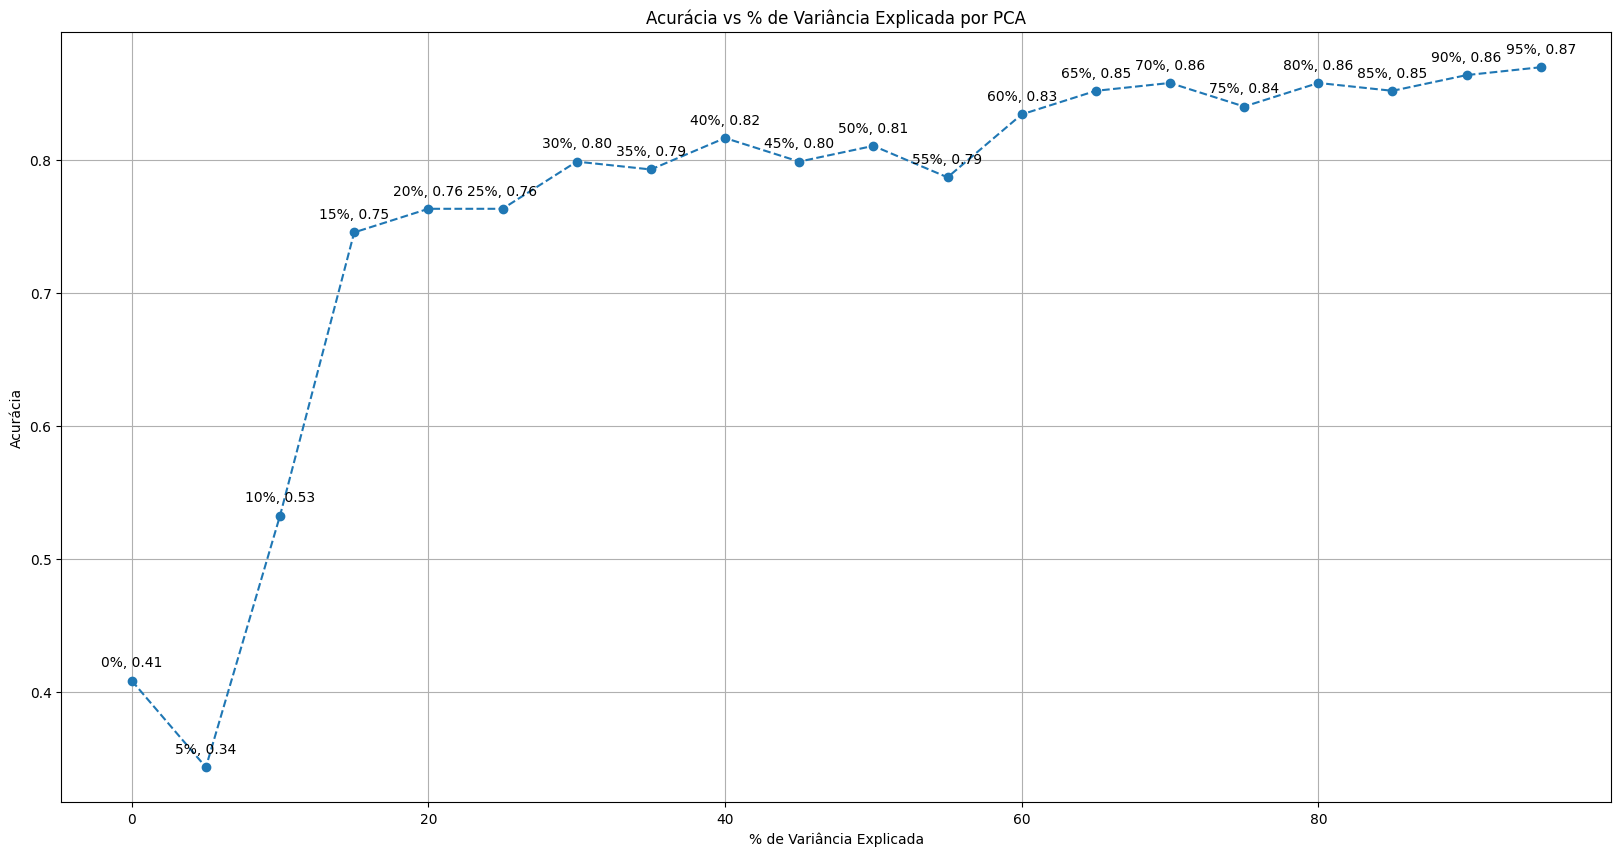

In [13]:
# Plotar o gráfico de % de variância explicada vs acurácia com anotações
plt.figure(figsize=(20, 10))
plt.plot(variances * 100, accuracies, marker='o', linestyle='--')
plt.xlabel('% de Variância Explicada')
plt.ylabel('Acurácia')
plt.title('Acurácia vs % de Variância Explicada por PCA')
plt.grid(True)

# Adicionar anotações aos pontos
for i, (var, acc) in enumerate(zip(variances * 100, accuracies)):
    plt.annotate(f'{var:.0f}%, {acc:.2f}', (var, acc), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


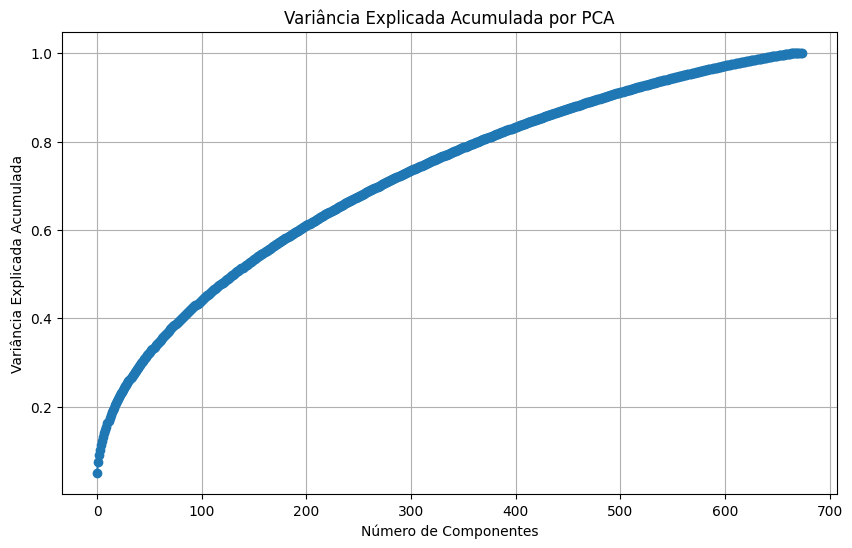


Avaliando para 0% de variância explicada:
Número de componentes para explicar 0% da variância: 1
Tamanho das features depois do PCA (train): (674, 1)
Tamanho das features depois do PCA (test): (169, 1)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.56      1.00      0.72        95
         1.0       0.00      0.00      0.00        74

    accuracy                           0.56       169
   macro avg       0.28      0.50      0.36       169
weighted avg       0.32      0.56      0.40       169

Acurácia: 0.5621

Avaliando para 5% de variância explicada:
Número de componentes para explicar 5% da variância: 2
Tamanho das features depois do PCA (train): (674, 2)
Tamanho das features depois do PCA (test): (169, 2)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.56      1.00      0.72        95
         1.0       0.00      0.00      0.00        74

    accuracy                           0.56       169
   macro avg       0.28      0.50      0.36       169
weighted avg       0.32      0.56      0.40       169

Acurácia: 0.5621

Avaliando para 10% de variância explicada:
Número de componentes para explicar 10% da variância: 4
Tamanho das features depois do PCA (train): (674, 4)
Tamanho das features depois do PCA (test): (169, 4)
              precision    recall  f1-score   support

         0.0       0.67      0.86      0.76        95
         1.0       0.72      0.46      0.56        74

    accuracy                           0.69       169
   macro avg       0.70      0.66      0.66       169
weighted avg       0.69      0.69      0.67       169

Acurácia: 0.6864

Avaliando para 15% de variância explicada:
Número de componentes para explicar 15% da variância: 10
Tamanh

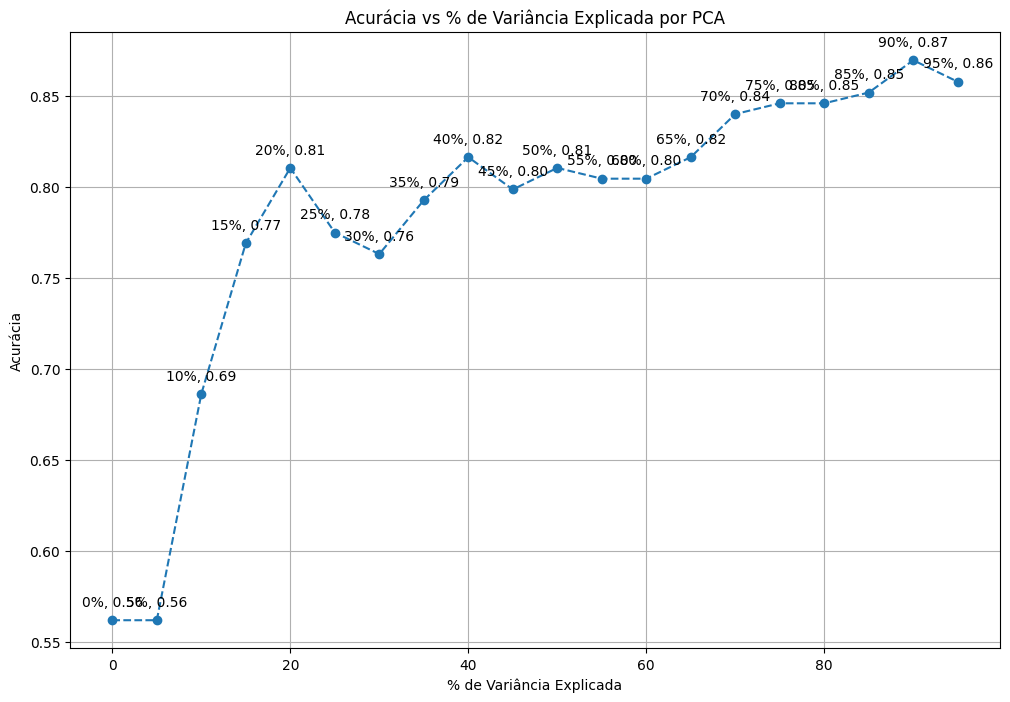

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

# Fixar a semente para operações determinísticas
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Função para treinar e avaliar o modelo e retornar a acurácia
def train_evaluate_pca_variance(explained_variance_threshold):
    # Determinar o número de componentes para o limiar de variância explicada
    n_components = np.argmax(explained_variance >= explained_variance_threshold) + 1

    print(f"Número de componentes para explicar {int(explained_variance_threshold * 100)}% da variância: {n_components}")

    # Aplicar PCA com o número de componentes determinado
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(combined_features_train_scaled)
    X_test_pca = pca.transform(combined_features_test_scaled)

    # Imprimir o tamanho das features depois do PCA
    print(f"Tamanho das features depois do PCA (train): {X_train_pca.shape}")
    print(f"Tamanho das features depois do PCA (test): {X_test_pca.shape}")

    # Treinar o classificador SVM com kernel sigmoide
    classifier = SVC(kernel='linear',random_state = 42)
    classifier.fit(X_train_pca, Y_train)

    # Avaliar o modelo
    Y_pred = classifier.predict(X_test_pca)

    # Imprimir o relatório de classificação
    print(classification_report(Y_test, Y_pred))

    # Calcular e imprimir a acurácia
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f"Acurácia: {accuracy:.4f}")
    
    return accuracy



# Concatenar as features extraídas
combined_features_train = np.concatenate([
    features_vgg_train, 
    features_resnet_train, 
    features_inception_train, 
    features_mobilenet_train, 
    features_efficientnet_train
], axis=1)

combined_features_test = np.concatenate([
    features_vgg_test, 
    features_resnet_test, 
    features_inception_test, 
    features_mobilenet_test, 
    features_efficientnet_test
], axis=1)

# Escalar as features antes de aplicar PCA
scaler = StandardScaler()
combined_features_train_scaled = scaler.fit_transform(combined_features_train)
combined_features_test_scaled = scaler.transform(combined_features_test)

# Aplicar PCA inicial para determinar a variância explicada acumulada
pca = PCA().fit(combined_features_train_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotar a variância explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por PCA')
plt.grid(True)
plt.show()

# Testar diferentes limiares de variância explicada e armazenar resultados
variances = np.arange(0, 1.0, 0.05)
accuracies = []

for threshold in variances:
    print(f"\nAvaliando para {int(threshold * 100)}% de variância explicada:")
    accuracy = train_evaluate_pca_variance(threshold)
    accuracies.append(accuracy)

# Plotar o gráfico de % de variância explicada vs acurácia com anotações
plt.figure(figsize=(12, 8))
plt.plot(variances * 100, accuracies, marker='o', linestyle='--')
plt.xlabel('% de Variância Explicada')
plt.ylabel('Acurácia')
plt.title('Acurácia vs % de Variância Explicada por PCA')
plt.grid(True)

# Adicionar anotações aos pontos
for i, (var, acc) in enumerate(zip(variances * 100, accuracies)):
    plt.annotate(f'{var:.0f}%, {acc:.2f}', (var, acc), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


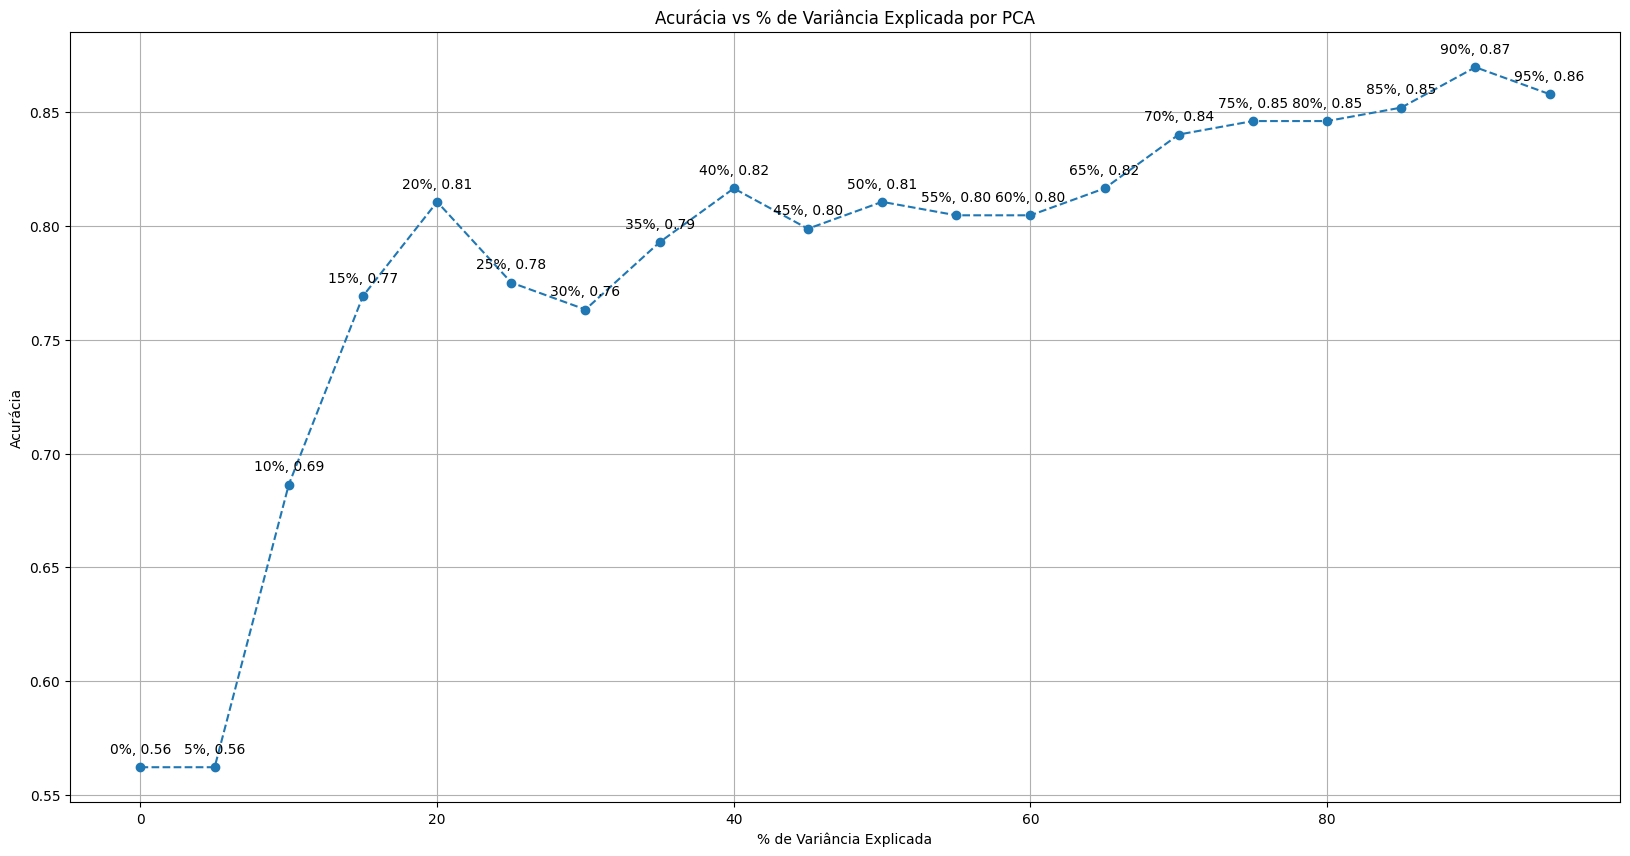

In [15]:
# Plotar o gráfico de % de variância explicada vs acurácia com anotações
plt.figure(figsize=(20, 10))
plt.plot(variances * 100, accuracies, marker='o', linestyle='--')
plt.xlabel('% de Variância Explicada')
plt.ylabel('Acurácia')
plt.title('Acurácia vs % de Variância Explicada por PCA')
plt.grid(True)

# Adicionar anotações aos pontos
for i, (var, acc) in enumerate(zip(variances * 100, accuracies)):
    plt.annotate(f'{var:.0f}%, {acc:.2f}', (var, acc), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


# **REDE NEURAL**

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Função para pré-processar a imagem
def preprocess_image(image, model_name):
    if model_name == 'vgg':
        return preprocess_vgg(image)
    elif model_name == 'resnet':
        return preprocess_resnet(image)
    elif model_name == 'inception':
        return preprocess_inception(image)
    elif model_name == 'mobilenet':
        return preprocess_mobilenet(image)
    elif model_name == 'efficientnet':
        return preprocess_efficientnet(image)

# Redimensionar todas as imagens para 224x224
def resize_image(image):
    return tf.image.resize(image, (224, 224))

# Carregar os modelos base sem a camada fully connected
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Função para extrair features
def extract_features(model, images, model_name):
    preprocessed_images = np.array([preprocess_image(resize_image(img), model_name) for img in images])
    features = model.predict(preprocessed_images)
    return features.reshape(features.shape[0], -1)

# Extrair features para o conjunto de treinamento
features_vgg_train = extract_features(base_model_vgg, X_train, 'vgg')
features_resnet_train = extract_features(base_model_resnet, X_train, 'resnet')
features_inception_train = extract_features(base_model_inception, X_train, 'inception')
features_mobilenet_train = extract_features(base_model_mobilenet, X_train, 'mobilenet')
features_efficientnet_train = extract_features(base_model_efficientnet, X_train, 'efficientnet')

# Concatenar as features extraídas
combined_features_train = np.concatenate([
    features_vgg_train, 
    features_resnet_train, 
    features_inception_train, 
    features_mobilenet_train, 
    features_efficientnet_train
], axis=1)

# Extrair features para o conjunto de teste
features_vgg_test = extract_features(base_model_vgg, X_test, 'vgg')
features_resnet_test = extract_features(base_model_resnet, X_test, 'resnet')
features_inception_test = extract_features(base_model_inception, X_test, 'inception')
features_mobilenet_test = extract_features(base_model_mobilenet, X_test, 'mobilenet')
features_efficientnet_test = extract_features(base_model_efficientnet, X_test, 'efficientnet')

# Concatenar as features extraídas
combined_features_test = np.concatenate([
    features_vgg_test, 
    features_resnet_test, 
    features_inception_test, 
    features_mobilenet_test, 
    features_efficientnet_test
], axis=1)

# Escalar as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(combined_features_train)
X_test_scaled = scaler.transform(combined_features_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 600ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assumindo que Y_train e Y_test sejam labels binários (0 ou 1)
Y_train_cat = to_categorical(Y_train, num_classes=2)
Y_test_cat = to_categorical(Y_test, num_classes=2)

# Definir a rede neural para fusão de features
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definir os callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Treinar o modelo
model.fit(X_train_scaled, Y_train_cat, epochs=100, batch_size=32, validation_split=0.2,
          callbacks=[early_stopping, reduce_lr])

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test_scaled, Y_test_cat)
print(f"Acurácia: {accuracy:.4f}")

# Prever e imprimir o relatório de classificação
Y_pred_nn = model.predict(X_test_scaled)
Y_pred_classes = np.argmax(Y_pred_nn, axis=1)
print(classification_report(Y_test, Y_pred_classes))



/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6198 - loss: 5.4703

W0000 00:00:1721071505.153564     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.6239 - loss: 11.7257

W0000 00:00:1721071513.979023     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721071514.813641     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 691ms/step - accuracy: 0.6249 - loss: 11.8520 - val_accuracy: 0.7778 - val_loss: 10.8444 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7791 - loss: 14.2387 - val_accuracy: 0.6815 - val_loss: 12.7553 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.8082 - loss: 11.2841 - val_accuracy: 0.7926 - val_loss: 5.8151 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8898 - loss: 3.3264 - val_accuracy: 0.7481 - val_loss: 9.5761 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9302 - loss: 3.2298 - val_accuracy: 0.7852 - val_loss: 12.3940 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9561 - loss: 2.5692 - val_accuracy: 0.7926 - val_loss: 14.2198 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9579 - loss: 1.7411 - va

W0000 00:00:1721071532.166739     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
              precision    recall  f1-score   support

         0.0       0.79      0.93      0.85        95
         1.0       0.88      0.68      0.76        74

    accuracy                           0.82       169
   macro avg       0.83      0.80      0.81       169
weighted avg       0.83      0.82      0.81       169



22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 329ms/step - accuracy: 0.5213 - loss: 2.7511 - val_accuracy: 0.6519 - val_loss: 2.0052 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5478 - loss: 1.6729 - val_accuracy: 0.6519 - val_loss: 1.0184 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5479 - loss: 1.1885 - val_accuracy: 0.6519 - val_loss: 0.8684 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5552 - loss: 0.9971 - val_accuracy: 0.6519 - val_loss: 0.7306 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4916 - loss: 1.0114 - val_accuracy: 0.5630 - val_loss: 0.6598 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5235 - loss: 0.9056 - val_accuracy: 0.6519 - val_loss: 0.6544 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5301 - loss: 0.8171 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 463ms/step - accuracy: 0.5204 - loss: 3.7714 - val_accuracy: 0.5778 - val_loss: 1.5246 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5353 - loss: 1.5970 - val_accuracy: 0.5185 - val_loss: 1.4138 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5100 - loss: 1.4343 - val_accuracy: 0.5333 - val_loss: 0.7675 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5638 - loss: 1.0812 - val_accuracy: 0.4815 - val_loss: 0.7211 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5161 - loss: 0.8911 - val_accuracy: 0.4296 - val_loss: 0.7419 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5031 - loss: 0.8818 - val_accuracy: 0.5481 - val_loss: 0.6644 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5811 - loss: 0.7649 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 431ms/step - accuracy: 0.5915 - loss: 3.5975 - val_accuracy: 0.6593 - val_loss: 1.8819 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5867 - loss: 2.1945 - val_accuracy: 0.6222 - val_loss: 1.3632 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5788 - loss: 1.5351 - val_accuracy: 0.6519 - val_loss: 0.6255 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5305 - loss: 1.1590 - val_accuracy: 0.6741 - val_loss: 0.6515 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6298 - loss: 0.8697 - val_accuracy: 0.6148 - val_loss: 0.6303 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6234 - loss: 0.8999 - val_accuracy: 0.6593 - val_loss: 0.6273 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6235 - loss: 0.7578 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.6001 - loss: 4.2421 - val_accuracy: 0.6000 - val_loss: 2.1945 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6689 - loss: 2.4681 - val_accuracy: 0.7333 - val_loss: 1.2052 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6862 - loss: 1.3232 - val_accuracy: 0.7407 - val_loss: 1.0308 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6864 - loss: 1.0953 - val_accuracy: 0.7630 - val_loss: 0.8434 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7339 - loss: 0.9222 - val_accuracy: 0.7185 - val_loss: 0.6873 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6724 - loss: 0.8419 - val_accuracy: 0.7111 - val_loss: 0.7235 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7353 - loss: 0.7287 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - accuracy: 0.5820 - loss: 5.0829 - val_accuracy: 0.6593 - val_loss: 2.2623 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6897 - loss: 2.0550 - val_accuracy: 0.7556 - val_loss: 1.0907 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7309 - loss: 1.2158 - val_accuracy: 0.7333 - val_loss: 1.1545 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7370 - loss: 1.3536 - val_accuracy: 0.7407 - val_loss: 0.7646 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7498 - loss: 0.9286 - val_accuracy: 0.7778 - val_loss: 0.8054 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8035 - loss: 0.7010 - val_accuracy: 0.7259 - val_loss: 0.8421 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7577 - loss: 0.8081 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 446ms/step - accuracy: 0.5714 - loss: 5.1013 - val_accuracy: 0.7407 - val_loss: 1.7891 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7348 - loss: 2.1152 - val_accuracy: 0.7481 - val_loss: 0.9124 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7261 - loss: 1.4792 - val_accuracy: 0.6667 - val_loss: 1.2025 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7445 - loss: 1.3809 - val_accuracy: 0.6519 - val_loss: 0.9989 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7320 - loss: 1.2616 - val_accuracy: 0.7037 - val_loss: 0.9405 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7956 - loss: 0.7442 - val_accuracy: 0.6741 - val_loss: 0.8841 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7669 - loss: 0.7402 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - accuracy: 0.5554 - loss: 7.8751 - val_accuracy: 0.7259 - val_loss: 1.4480 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6984 - loss: 2.2275 - val_accuracy: 0.7333 - val_loss: 1.1260 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7215 - loss: 1.7433 - val_accuracy: 0.7852 - val_loss: 0.8775 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7818 - loss: 1.1063 - val_accuracy: 0.7778 - val_loss: 0.9055 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7876 - loss: 1.0967 - val_accuracy: 0.7111 - val_loss: 0.9732 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8037 - loss: 0.7177 - val_accuracy: 0.7407 - val_loss: 0.7077 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8025 - loss: 0.5105 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 460ms/step - accuracy: 0.5556 - loss: 7.1793 - val_accuracy: 0.6593 - val_loss: 2.2582 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6953 - loss: 2.5360 - val_accuracy: 0.6889 - val_loss: 1.4268 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7649 - loss: 1.5890 - val_accuracy: 0.6815 - val_loss: 1.2350 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8104 - loss: 1.1108 - val_accuracy: 0.7407 - val_loss: 1.0297 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7774 - loss: 1.2727 - val_accuracy: 0.7778 - val_loss: 0.7898 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8041 - loss: 1.0768 - val_accuracy: 0.6815 - val_loss: 1.2231 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8176 - loss: 0.7582 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 461ms/step - accuracy: 0.5439 - loss: 7.5408 - val_accuracy: 0.7259 - val_loss: 1.4867 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7343 - loss: 1.9712 - val_accuracy: 0.7481 - val_loss: 0.9687 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7548 - loss: 1.3102 - val_accuracy: 0.7704 - val_loss: 0.6740 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7869 - loss: 1.1319 - val_accuracy: 0.7778 - val_loss: 0.6814 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8300 - loss: 0.7893 - val_accuracy: 0.6593 - val_loss: 0.9910 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8257 - loss: 0.5680 - val_accuracy: 0.6741 - val_loss: 0.9195 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8251 - loss: 0.6830 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 465ms/step - accuracy: 0.5435 - loss: 7.2833 - val_accuracy: 0.7407 - val_loss: 1.4715 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7262 - loss: 2.4354 - val_accuracy: 0.8148 - val_loss: 1.0067 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7935 - loss: 1.5984 - val_accuracy: 0.8148 - val_loss: 0.8984 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8149 - loss: 1.0657 - val_accuracy: 0.7556 - val_loss: 1.0829 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7928 - loss: 0.9348 - val_accuracy: 0.7259 - val_loss: 1.0452 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8052 - loss: 0.8493 - val_accuracy: 0.7778 - val_loss: 0.9300 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8509 - loss: 0.6681 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 463ms/step - accuracy: 0.5409 - loss: 7.4927 - val_accuracy: 0.6889 - val_loss: 2.0265 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7570 - loss: 2.2794 - val_accuracy: 0.7556 - val_loss: 1.1128 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7804 - loss: 1.5335 - val_accuracy: 0.7704 - val_loss: 0.8616 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8350 - loss: 0.9047 - val_accuracy: 0.7704 - val_loss: 0.9336 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8453 - loss: 0.7557 - val_accuracy: 0.8074 - val_loss: 0.8370 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8396 - loss: 0.7727 - val_accuracy: 0.7926 - val_loss: 0.8389 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8889 - loss: 0.5015 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 469ms/step - accuracy: 0.4580 - loss: 13.3335 - val_accuracy: 0.7111 - val_loss: 2.1141 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7447 - loss: 1.9350 - val_accuracy: 0.7407 - val_loss: 1.4264 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7612 - loss: 1.9120 - val_accuracy: 0.6593 - val_loss: 1.7255 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7985 - loss: 1.4330 - val_accuracy: 0.6889 - val_loss: 1.4018 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7961 - loss: 1.1129 - val_accuracy: 0.6889 - val_loss: 1.3007 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.6251 - val_accuracy: 0.7037 - val_loss: 1.1101 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8616 - loss: 0.5768 - val_accuracy: 0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 461ms/step - accuracy: 0.5324 - loss: 7.9725 - val_accuracy: 0.7333 - val_loss: 2.1151 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7405 - loss: 2.3145 - val_accuracy: 0.7556 - val_loss: 1.6022 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7804 - loss: 1.6817 - val_accuracy: 0.7926 - val_loss: 1.2753 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8222 - loss: 0.9810 - val_accuracy: 0.7630 - val_loss: 1.3046 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8527 - loss: 0.7637 - val_accuracy: 0.6963 - val_loss: 1.3007 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8568 - loss: 0.6604 - val_accuracy: 0.7333 - val_loss: 1.1396 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8437 - loss: 0.7609 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - accuracy: 0.5482 - loss: 7.2714 - val_accuracy: 0.6074 - val_loss: 2.1668 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7148 - loss: 2.4559 - val_accuracy: 0.7926 - val_loss: 1.1441 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7858 - loss: 1.3683 - val_accuracy: 0.8222 - val_loss: 1.1492 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8242 - loss: 0.8605 - val_accuracy: 0.7926 - val_loss: 0.9342 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8628 - loss: 0.5536 - val_accuracy: 0.6296 - val_loss: 1.7036 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8673 - loss: 0.5932 - val_accuracy: 0.8148 - val_loss: 0.9174 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9107 - loss: 0.3612 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 469ms/step - accuracy: 0.5337 - loss: 9.5522 - val_accuracy: 0.6963 - val_loss: 2.0084 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7440 - loss: 2.2766 - val_accuracy: 0.7778 - val_loss: 2.3064 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7643 - loss: 1.6626 - val_accuracy: 0.7037 - val_loss: 1.3984 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8161 - loss: 1.0174 - val_accuracy: 0.7185 - val_loss: 1.3425 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8668 - loss: 0.6916 - val_accuracy: 0.7037 - val_loss: 1.4610 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8855 - loss: 0.5297 - val_accuracy: 0.7037 - val_loss: 1.2826 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8784 - loss: 0.4946 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 444ms/step - accuracy: 0.5574 - loss: 9.4083 - val_accuracy: 0.6444 - val_loss: 2.4032 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6988 - loss: 2.7293 - val_accuracy: 0.5778 - val_loss: 2.1947 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8098 - loss: 0.9742 - val_accuracy: 0.6370 - val_loss: 1.7753 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8278 - loss: 1.1709 - val_accuracy: 0.7852 - val_loss: 1.4798 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8810 - loss: 0.5333 - val_accuracy: 0.7259 - val_loss: 1.4572 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8546 - loss: 0.5928 - val_accuracy: 0.6815 - val_loss: 1.7481 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8943 - loss: 0.4092 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 439ms/step - accuracy: 0.5029 - loss: 13.2865 - val_accuracy: 0.7630 - val_loss: 2.2851 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7796 - loss: 2.0627 - val_accuracy: 0.7259 - val_loss: 2.2579 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8040 - loss: 1.8707 - val_accuracy: 0.7704 - val_loss: 2.0235 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8450 - loss: 1.2983 - val_accuracy: 0.7481 - val_loss: 1.4132 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8777 - loss: 0.8766 - val_accuracy: 0.7333 - val_loss: 1.3206 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8807 - loss: 0.6871 - val_accuracy: 0.7333 - val_loss: 2.1006 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9014 - loss: 0.6662 - val_accuracy: 0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 448ms/step - accuracy: 0.5415 - loss: 5.9492 - val_accuracy: 0.7111 - val_loss: 3.3115 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7899 - loss: 1.8346 - val_accuracy: 0.7630 - val_loss: 2.1786 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8244 - loss: 1.4449 - val_accuracy: 0.7704 - val_loss: 1.9092 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8872 - loss: 0.8635 - val_accuracy: 0.6222 - val_loss: 3.1975 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8902 - loss: 0.9821 - val_accuracy: 0.8074 - val_loss: 1.5496 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9314 - loss: 0.3452 - val_accuracy: 0.7556 - val_loss: 1.5833 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9437 - loss: 0.2782 - val_accuracy: 0.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:25 5s/step - accuracy: 0.4375 - loss: 12.3140

W0000 00:00:1721072157.153809     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.5213 - loss: 10.6676

W0000 00:00:1721072163.669051     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721072164.059061     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 446ms/step - accuracy: 0.5238 - loss: 10.5224 - val_accuracy: 0.6741 - val_loss: 2.8031 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7448 - loss: 2.3456 - val_accuracy: 0.7111 - val_loss: 1.8818 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7965 - loss: 1.9119 - val_accuracy: 0.7111 - val_loss: 1.5573 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8504 - loss: 0.8298 - val_accuracy: 0.6222 - val_loss: 1.6307 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8574 - loss: 0.7397 - val_accuracy: 0.6889 - val_loss: 1.3555 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9178 - loss: 0.3892 - val_accuracy: 0.7630 - val_loss: 1.2298 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9175 - loss: 0.3741 - val_accuracy: 0

W0000 00:00:1721072166.167350     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85        95
         1.0       0.82      0.76      0.79        74

    accuracy                           0.82       169
   macro avg       0.82      0.82      0.82       169
weighted avg       0.82      0.82      0.82       169

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:28 6s/step - accuracy: 0.7188 - loss: 7.8159

W0000 00:00:1721072213.053181     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5721 - loss: 8.5166

W0000 00:00:1721072220.025658     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721072220.414084     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 474ms/step - accuracy: 0.5700 - loss: 8.4786 - val_accuracy: 0.6593 - val_loss: 2.7163 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7522 - loss: 2.8047 - val_accuracy: 0.6815 - val_loss: 1.8377 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8359 - loss: 1.1344 - val_accuracy: 0.6148 - val_loss: 2.4320 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8529 - loss: 0.9103 - val_accuracy: 0.6296 - val_loss: 2.5433 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8862 - loss: 0.7334 - val_accuracy: 0.7926 - val_loss: 1.5687 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9028 - loss: 0.4722 - val_accuracy: 0.7481 - val_loss: 1.5531 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9683 - loss: 0.1523 - val_accuracy: 0.

W0000 00:00:1721072222.293549     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

         0.0       0.78      0.95      0.86        95
         1.0       0.91      0.66      0.77        74

    accuracy                           0.82       169
   macro avg       0.85      0.80      0.81       169
weighted avg       0.84      0.82      0.82       169

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:42 6s/step - accuracy: 0.4375 - loss: 11.4785

W0000 00:00:1721072270.121648     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4987 - loss: 10.4980

W0000 00:00:1721072277.049228     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721072277.449102     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 472ms/step - accuracy: 0.5007 - loss: 10.3517 - val_accuracy: 0.6000 - val_loss: 2.4245 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7741 - loss: 2.0104 - val_accuracy: 0.6074 - val_loss: 2.0068 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8361 - loss: 1.0031 - val_accuracy: 0.6741 - val_loss: 2.3257 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8497 - loss: 1.0967 - val_accuracy: 0.6741 - val_loss: 1.5829 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8972 - loss: 0.7309 - val_accuracy: 0.6000 - val_loss: 2.9626 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9239 - loss: 0.4809 - val_accuracy: 0.7407 - val_loss: 1.8849 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9570 - loss: 0.3508 - val_accuracy: 0

W0000 00:00:1721072279.504185     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86        95
         1.0       0.89      0.68      0.77        74

    accuracy                           0.82       169
   macro avg       0.84      0.81      0.81       169
weighted avg       0.83      0.82      0.82       169



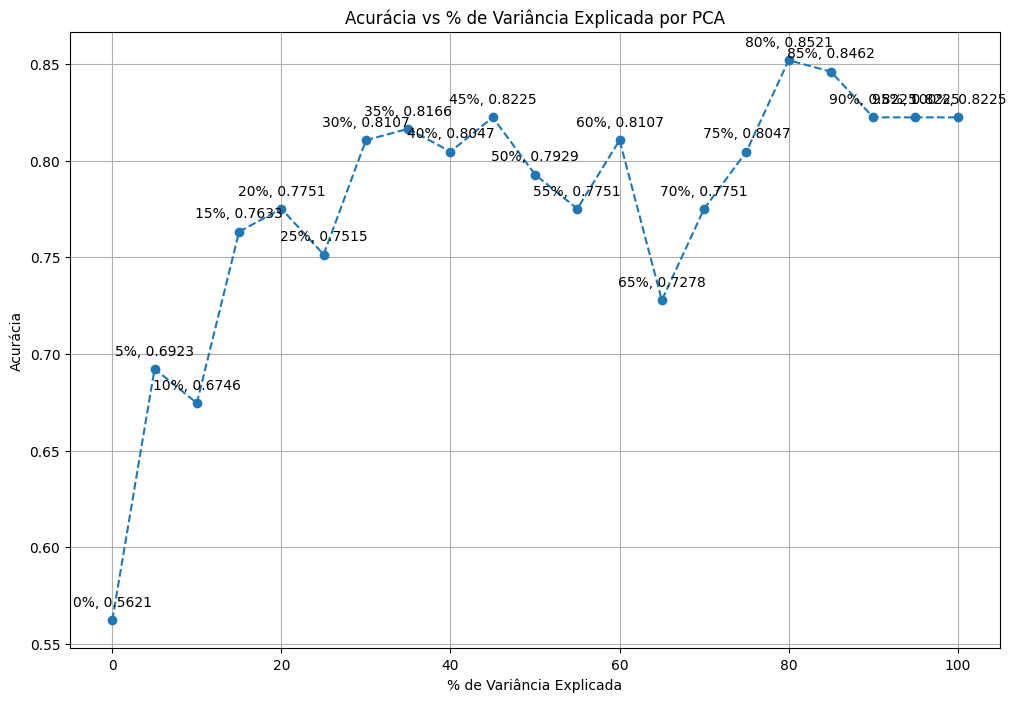

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Função para pré-processar a imagem
def preprocess_image(image, model_name):
    if model_name == 'vgg':
        return preprocess_vgg(image)
    elif model_name == 'resnet':
        return preprocess_resnet(image)
    elif model_name == 'inception':
        return preprocess_inception(image)
    elif model_name == 'mobilenet':
        return preprocess_mobilenet(image)
    elif model_name == 'efficientnet':
        return preprocess_efficientnet(image)

# Redimensionar todas as imagens para 224x224
def resize_image(image):
    return tf.image.resize(image, (224, 224))

# Carregar os modelos base sem a camada fully connected
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Função para extrair features
def extract_features(model, images, model_name):
    preprocessed_images = np.array([preprocess_image(resize_image(img), model_name) for img in images])
    features = model.predict(preprocessed_images)
    return features.reshape(features.shape[0], -1)

# Arrays de dados
# X_train e X_test contêm as imagens já carregadas e Y_train, Y_test contêm os rótulos
# Assegure-se de que as imagens estejam dimensionadas corretamente para cada modelo
# X_train, X_test, Y_train, Y_test = ...

# Extrair features para o conjunto de treinamento
features_vgg_train = extract_features(base_model_vgg, X_train, 'vgg')
features_resnet_train = extract_features(base_model_resnet, X_train, 'resnet')
features_inception_train = extract_features(base_model_inception, X_train, 'inception')
features_mobilenet_train = extract_features(base_model_mobilenet, X_train, 'mobilenet')
features_efficientnet_train = extract_features(base_model_efficientnet, X_train, 'efficientnet')

# Concatenar as features extraídas
combined_features_train = np.concatenate([
    features_vgg_train, 
    features_resnet_train, 
    features_inception_train, 
    features_mobilenet_train, 
    features_efficientnet_train
], axis=1)

# Extrair features para o conjunto de teste
features_vgg_test = extract_features(base_model_vgg, X_test, 'vgg')
features_resnet_test = extract_features(base_model_resnet, X_test, 'resnet')
features_inception_test = extract_features(base_model_inception, X_test, 'inception')
features_mobilenet_test = extract_features(base_model_mobilenet, X_test, 'mobilenet')
features_efficientnet_test = extract_features(base_model_efficientnet, X_test, 'efficientnet')

# Concatenar as features extraídas
combined_features_test = np.concatenate([
    features_vgg_test, 
    features_resnet_test, 
    features_inception_test, 
    features_mobilenet_test, 
    features_efficientnet_test
], axis=1)

# Escalar as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(combined_features_train)
X_test_scaled = scaler.transform(combined_features_test)

# Aplicar PCA inicial para determinar a variância explicada acumulada
pca = PCA().fit(X_train_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Função para treinar e avaliar o modelo com PCA
def train_evaluate_pca_variance(explained_variance_threshold):
    # Determinar o número de componentes para o limiar de variância explicada
    n_components = np.argmax(explained_variance >= explained_variance_threshold) + 1
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    Y_train_cat = to_categorical(Y_train, num_classes=2)
    Y_test_cat = to_categorical(Y_test, num_classes=2)

    # Definir a rede neural para fusão de features
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(X_train_pca.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Definir os callbacks
    early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    # Treinar o modelo
    model.fit(X_train_pca, Y_train_cat, epochs=100, batch_size=32, validation_split=0.2,
              callbacks=[early_stopping, reduce_lr])

    # Avaliar o modelo
    loss, accuracy = model.evaluate(X_test_pca, Y_test_cat)
    print(f"Acurácia com {explained_variance_threshold*100}% de variância explicada: {accuracy:.4f}")

    # Prever e imprimir o relatório de classificação
    Y_pred_nn = model.predict(X_test_pca)
    Y_pred_classes = np.argmax(Y_pred_nn, axis=1)
    print(classification_report(Y_test, Y_pred_classes))

    return accuracy

# Testar diferentes limiares de variância explicada 
variances = np.arange(0, 1.05, 0.05)
accuracies = []

for threshold in variances:
    accuracy = train_evaluate_pca_variance(threshold)
    accuracies.append(accuracy)

# Plotar o gráfico de % de variância explicada vs acurácia
plt.figure(figsize=(12, 8))
plt.plot(variances * 100, accuracies, marker='o', linestyle='--')
plt.xlabel('% de Variância Explicada')
plt.ylabel('Acurácia')
plt.title('Acurácia vs % de Variância Explicada por PCA')
plt.grid(True)

# Adicionar anotações aos pontos
for var, acc in zip(variances, accuracies):
    plt.annotate(f'{var*100:.0f}%, {acc:.4f}', (var * 100, acc), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()
